# Assignment Week 2 - Group 5

### Cosimo Attempt

Linear Regression and Logistic Regression Start for Wk2

Requires coliniearity to be added or merged into the file
Needs Either reisidual plot QQplot for models

In [1]:
import CambiCosimo_Functions as cc
#Some Functions to make this process easier and cleaner

In [2]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
#import seaborn as sns

In [3]:
filename1 = "fraudTrain.csv"
df_1 = pd.read_csv(filename1)
filename2 = "fraudTest.csv"
df_2 = pd.read_csv(filename2)

fraud_df = df_1.append(df_2)

In [4]:
fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

fraud_df['date_of_birth'] =  pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')
fraud_df['year_of_birth'] = fraud_df['date_of_birth'].dt.year
fraud_df['date_of_birth'] = fraud_df['date_of_birth'].dt.date

fraud_df['txn_date'] = fraud_df['txn_datetime'].dt.date

now = pd.to_datetime('now')
fraud_df['age'] = fraud_df.apply(lambda x: now.year - x['year_of_birth'], axis = 1)

fraud_df['txn_month'] = fraud_df['txn_datetime'].dt.month

In [5]:
#(dataframe, max number of unique values to show)
cc.UniqueValues(fraud_df,30)

Unnamed: 0: 1296675 unique values
trans_date_trans_time: 1819551 unique values
cc_num: 999 unique values
merchant: 693 unique values
category
['misc_net' 'grocery_pos' 'entertainment' 'gas_transport' 'misc_pos'
 'grocery_net' 'shopping_net' 'shopping_pos' 'food_dining' 'personal_care'
 'health_fitness' 'travel' 'kids_pets' 'home']
amt: 60616 unique values
first: 355 unique values
last: 486 unique values
gender
['F' 'M']
street: 999 unique values
city: 906 unique values
state: 51 unique values
zip: 985 unique values
lat: 983 unique values
long: 983 unique values
city_pop: 891 unique values
job: 497 unique values
dob: 984 unique values
trans_num: 1852394 unique values
unix_time: 1819583 unique values
merch_lat: 1754157 unique values
merch_long: 1809753 unique values
is_fraud
[0 1]
txn_datetime: 1819551 unique values
date_of_birth: 984 unique values
year_of_birth: 82 unique values
txn_date: 730 unique values
age: 82 unique values
txn_month
[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [6]:
#create target lables
#target 1 will be the continous variable for linear regression: amt
fraud_df['Target1'] = fraud_df['amt']
#target 2 will be a binary classification variable for logistic regression: is_fraud
fraud_df['Target2'] = fraud_df['is_fraud']

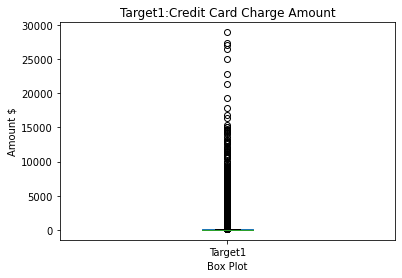

In [7]:
#review the distribution of the target variables
fraud_df['Target1'].plot.box()
plt.title('Target1:Credit Card Charge Amount')
plt.xlabel('Box Plot')
plt.ylabel('Amount $')
plt.show()

In [8]:
#The distribution of the amt is very wide with a small inter quartile, therefore
#we change Tartet 1 to the natural log of the amt to transform it to a feature 
#that has a tighter distribution
fraud_df['Target1'] = fraud_df['log_amt'] = fraud_df['amt'].apply(lambda x: m.log(x))

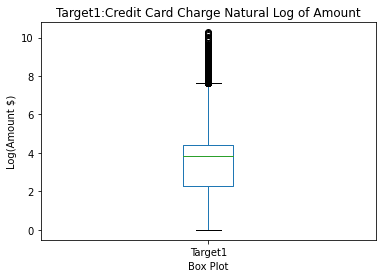

In [9]:
#review the distribution of the target variables
fraud_df['Target1'].plot.box()
plt.title('Target1:Credit Card Charge Natural Log of Amount')
plt.xlabel('Box Plot')
plt.ylabel('Log(Amount $)')
plt.show()

In [10]:
#Review the prevalence of the positive class for target2
print('Prevalence of the positive class for Target2: {:.3f}'.format(cc.calc_prevalence(fraud_df['Target2'].values)))

Prevalence of the positive class for Target2: 0.005


In [11]:
#create a lis to hold our categorical columns and one to hold our numerical columns
cat_col = ['category','gender','txn_month']
num_col_linr = ['age']
num_col_logr = ['age','log_amt']

In [12]:
#make sure there are no missing values 
print(fraud_df[cat_col].isnull().sum().sort_values(ascending = False).head(50))
print(fraud_df[num_col_linr].isnull().sum().sort_values(ascending = False).head(50))
print(fraud_df[num_col_logr].isnull().sum().sort_values(ascending = False).head(50))

txn_month    0
gender       0
category     0
dtype: int64
age    0
dtype: int64
log_amt    0
age        0
dtype: int64


In [13]:
#In order for categorical columns to work we have to one hot encode them
if len(cat_col)>0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col],drop_first = True)
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

else:
    cols_cate_onehotencode = []

# Linear Regression

## Check the Features and Create input lists

In [14]:
print('Total number of features: {}'.format(len(num_col_linr + cat_col_onehotencode)))
print('Numerical Features: {}'.format(len(num_col_linr)))
print('Categorical Features: {}'.format(len(cat_col_onehotencode)))
input_col = (num_col_linr + cat_col_onehotencode)

Total number of features: 16
Numerical Features: 1
Categorical Features: 15


In [15]:
#build Training/Validation/Test Samples 
#(dataframe,randomseed,train split)
train,valid,test = cc.Train_Valid_Test_Split(fraud_df[input_col +['Target1']],12,.7)

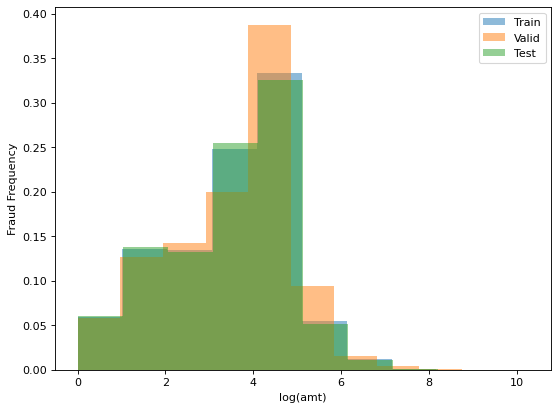

All samples (n = 1,852,394) accounted for.


In [16]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(train['Target1'], alpha=0.5, label='Train',density=True)
plt.hist(valid['Target1'], alpha=0.5, label='Valid',density=True)
plt.hist(test['Target1'], alpha=0.5, label='Test',density=True)
plt.legend(loc='upper right')
plt.title = ('log(amt) Distribution in Split Datasets')
plt.xlabel('log(amt)')
plt.ylabel('Fraud Frequency')
plt.show()

#check all records are accounted for
print('All samples (n = {:0,d}) accounted for.'.format(len(fraud_df)))
assert len(fraud_df) == (len(test)+len(valid)+len(train)),'math didnt work'


In [17]:
# create the X and y matrices for models
X_train = train[input_col].values
X_valid = valid[input_col].values
X_test = test[input_col].values

x_model = fraud_df[input_col].values

y_train = train['Target1'].values
y_valid = valid['Target1'].values
y_test = test['Target1'].values

In [18]:
#This creates scalars in order to scale the data so each variable is of similar size.
scaler  = StandardScaler()
scaler.fit(X_train)

# transform our data matrices - this applies our scalar and scales the matrices for training and validation data
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)



## Create the Model

In [19]:
help(ElasticNet())

Help on ElasticNet in module sklearn.linear_model._coordinate_descent object:

class ElasticNet(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, sklearn.linear_model._base.LinearModel)
 |  ElasticNet(alpha=1.0, *, l1_ratio=0.5, fit_intercept=True, normalize=False, precompute=False, max_iter=1000, copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
 |  
 |  Linear regression with combined L1 and L2 priors as regularizer.
 |  
 |  Minimizes the objective function::
 |  
 |          1 / (2 * n_samples) * ||y - Xw||^2_2
 |          + alpha * l1_ratio * ||w||_1
 |          + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2
 |  
 |  If you are interested in controlling the L1 and L2 penalty
 |  separately, keep in mind that this is equivalent to::
 |  
 |          a * L1 + b * L2
 |  
 |  where::
 |  
 |          alpha = a + b and l1_ratio = a / (a + b)
 |  
 |  The parameter l1_ratio corresponds to alpha in the glmnet R package while
 |  alph

In [20]:
#Create a Baseline Model
linr=LinearRegression(n_jobs=-1)
linr.fit(X_train_tf, y_train)

linr_y_valid_pred = linr.predict(X_valid_tf)


In [21]:
#linr.score(X_train_tf,y_train)

In [22]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_valid, linr_y_valid_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_valid, linr_y_valid_pred))

Mean squared error: 1.53
Coefficient of determination: 0.20


In [23]:
#create a model using regularization
#ElasticNet allows for a combination of L1 and L2 regularization
enet = ElasticNet(random_state=12)
enet.fit(X_train_tf, y_train)

enet_y_valid_pred = enet.predict(X_valid_tf)

In [24]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_valid, enet_y_valid_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_valid, enet_y_valid_pred))

Mean squared error: 1.92
Coefficient of determination: -0.00


# Logistic Regression

## Check the Features and Create input lists

In [25]:
print('Total number of features: {}'.format(len(num_col_logr + cat_col_onehotencode)))
print('Numerical Features: {}'.format(len(num_col_logr)))
print('Categorical Features: {}'.format(len(cat_col_onehotencode)))
input_col = (num_col_logr + cat_col_onehotencode)

Total number of features: 17
Numerical Features: 2
Categorical Features: 15


In [26]:
#build Training/Validation/Test Samples 
#(dataframe,randomseed,train split)
train,valid,test = cc.Train_Valid_Test_Split(fraud_df[input_col +['Target2']],12,.7)

In [27]:
# check the prevalence of each subset for target 2
print('Target2 checks:')
print('Test prevalence(n = {:0,d}):{:.3f}'.format(len(test),cc.calc_prevalence(test.Target2.values)))
print('Valid prevalence(n = {:0,d}):{:.3f}'.format(len(valid),cc.calc_prevalence(valid.Target2.values)))
print('Train all prevalence(n = {:0,d}):{:.3f}'.format(len(train),cc.calc_prevalence(train.Target2.values)))

#check all records are accounted for
print('All samples (n = {:0,d}) accounted for.'.format(len(fraud_df)))
assert len(fraud_df) == (len(test)+len(valid)+len(train)),'math didnt work'

Target2 checks:
Test prevalence(n = 277,859):0.005
Valid prevalence(n = 277,859):0.005
Train all prevalence(n = 1,296,676):0.005
All samples (n = 1,852,394) accounted for.


In [28]:
#(dataframe, 'Sub' or 'Over',output or target label)
train_bal = cc.balance_train_df(train,'Sub','Target2')

Balance Method Used is  Sub
Train balanced prevalence(n = 13,480):0.500


In [29]:
# create the X and y matrices for models
X_train = train_bal[input_col].values
X_valid = valid[input_col].values
X_test = test[input_col].values

y_train = train_bal['Target2'].values
y_valid = valid['Target2'].values
y_test = test['Target2'].values

In [30]:
#This creates scalars in order to scale the data so each variable is of similar size.
scaler  = StandardScaler()
scaler.fit(X_train)

# transform our data matrices - this applies our scalar and scales the matrices for training and validation data
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)

## Create The Model

In [31]:
auc_scoring = make_scorer(roc_auc_score)

In [32]:
#Create a Baseline Model
lr=LogisticRegression(random_state = 12)

lr.fit(X_train_tf, y_train)

y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

In [33]:
#Create grid Optimized Model

#C
C = [0.02,1.2,2]
#dual
dual = [False,True]
# fit_intercept 
fit_intercept = [False,True]
#max_iter
max_iter = [10,50,100]
#n_jobs
n_jobs = [-1]
#penalty
penalty = ['l1', 'l2']
#solver 
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#warm_start
warm_start = [False,True]

#param_grid

param_grid_lr = {'C':C,
                'dual':dual,
                'max_iter':max_iter,
                'fit_intercept':fit_intercept,
                'n_jobs':n_jobs,
                'penalty':penalty,
                'solver':solver,
                'warm_start':warm_start}

#print(full_grid_lr)


# create the cross-validation by grid method
lr_grid = GridSearchCV(estimator = lr, param_grid = param_grid_lr, 
                            cv = 3, scoring=auc_scoring,verbose = 1, n_jobs = -1, 
                            error_score=0)

# fit the grid search model (this will take a few minutes)
lr_grid.fit(X_train_tf, y_train)

print(lr_grid.best_params_)
thresh = 0.5

print('Baseline Logistic Regression')
lr_train_base_auc = roc_auc_score(y_train, y_train_preds)
lr_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:{:.3f}'.format(lr_train_base_auc))
print('Validation AUC:{:.3f}'.format(lr_valid_base_auc))

print('Optimized Logistic Regression')
y_train_preds_grid = lr_grid.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_grid = lr_grid.best_estimator_.predict_proba(X_valid_tf)[:,1]

lr_train_opt_auc = roc_auc_score(y_train, y_train_preds_grid)
lr_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_grid)

print('Training AUC:{:.3f}'.format(lr_train_opt_auc))
print('Validation AUC:{:.3f}'.format(lr_valid_opt_auc))

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   13.8s finished
C:\Users\ccambi\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.02, 'dual': False, 'fit_intercept': True, 'max_iter': 10, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'saga', 'warm_start': False}
Baseline Logistic Regression
Training AUC:0.848
Validation AUC:0.855
Optimized Logistic Regression
Training AUC:0.845
Validation AUC:0.853


In [34]:
y_test_preds_grid = lr_grid.best_estimator_.predict_proba(X_test_tf)[:,1]

print('LR Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = cc.print_report(y_train,y_train_preds_grid, thresh)
print('LR Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = cc.print_report(y_valid,y_valid_preds_grid, thresh)
print('LR Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = cc.print_report(y_test,y_test_preds_grid, thresh)


LR Training:
AUC:0.845
accuracy:0.752
recall:0.740
precision:0.758
specificity:0.763
prevalence:0.500
 
LR Validation:
AUC:0.853
accuracy:0.760
recall:0.753
precision:0.016
specificity:0.760
prevalence:0.005
 
LR Test:
AUC:0.844
accuracy:0.760
recall:0.736
precision:0.016
specificity:0.760
prevalence:0.005
 
